In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes/diabetes.csv


Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki
Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları üzerinde
yapılan diyabet araştırması için kullanılan verilerdir.
Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [3]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


1- Veri setine genel bir bakış.

In [4]:

df=pd.read_csv("/kaggle/input/diabetes/diabetes.csv")
df.head()
df.info()   ## int ve float türünde veriler mevcut. Hedef değişkenimiz Outcome.
df.shape  ## 768  gözlem ve 9 feature mevcut.
df.describe().T

for col in df.columns:
    print(f"Sütun Adı: {df[col].name} \n"
          f"Benzersiz Değer Sayısı : {df[col].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
Sütun Adı: Pregnancies 
Benzersiz Değer Sayısı : 17
Sütun Adı: Glucose 
Benzersiz Değer Sayısı : 136
Sütun Adı: BloodPressure 
Benzersiz Değer Sayısı : 47
Sütun Adı: SkinThickness 
Benzersiz Değer Sayısı : 51
Sütun Adı: Insulin 
Benzersiz D

2- Numerik ve Kategorik Değişkenler 

In [5]:

def grab_col_names(dataframe,cat_th=10,car_th=20):
    cat_cols=[col for col in dataframe.columns if dataframe[col].dtypes == "0"]  ## Özellik tipi object ise cat_cols olarak alır.
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]   #benzersiz değeri 10'un altında ve tipi object değil ise bu değerleerde categorik olarak alınır.


    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique()>car_th and
             dataframe[col].dtypes=="O"] # Özellik tip object fakat benzersiz değeri 20'den fazla ise bu değerler kardinal değerler olarak geçer. Veri setimizin değerini etkielyecek özellikte değildir.
    # Mesela hastaların adı olabilir.

    cat_cols=cat_cols + num_but_cat
    cat_cols=[col for col in cat_cols if col not in cat_but_car]

    #num_cols
    num_cols=[col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols= [col for col in num_cols if col not in num_but_cat]


    print(f"Observation: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols,num_cols,cat_but_car
cat_cols,num_cols,cat_but_car=grab_col_names(df)


Observation: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


3- Hedef değişkenin diğer değişkenler ile  analizi

In [6]:

result = df.groupby("Outcome").agg({
    "Pregnancies": "mean",
    "Insulin": "mean",
    "Glucose": "mean",
    "BloodPressure": "mean",
    "SkinThickness": "mean",
    "BMI": "mean",
    "DiabetesPedigreeFunction": "mean",
    "Age": "mean"
})
print(result)

         Pregnancies  Insulin  Glucose  BloodPressure  SkinThickness    BMI  DiabetesPedigreeFunction    Age
Outcome                                                                                                     
0              3.298   68.792  109.980         68.184         19.664 30.304                     0.430 31.190
1              4.866  100.336  141.257         70.825         22.164 35.143                     0.550 37.067


4- Aykırı gözlem analizi.
Eşik noktası belirlenir.
Aykırı değer var mı yok mu kontrol edilir.

In [7]:

def outlier_thresholds(dataframe,col_name,q1=0.25,q3=0.75): ## Alt ve üst eşik değeri hesaplamak için kullanırız.
    quartile1=dataframe[col_name].quantile(q1) ## Her sütunun çeyreklik değerini belirler.
    quartile3=dataframe[col_name].quantile(q3)
    iqr=quartile3 - quartile1  ## Çeyrekler arası farkı gösterir.
    up_limit=quartile3 + 1.5*iqr  # Üt limiti belirleriz.Bu değerin üstündekiler aykırı değerler.
    low_limit= quartile1 - 1.5 *iqr  #Alt limiti belirleriz. Bu değerin altındaki değerler aykırı değerlerdir.
    return low_limit,up_limit

def check_outlier(dataframe,col_name): #Aykırı değer içerip içermediğini kontrol eder.
    low_limit,up_limit=outlier_thresholds(dataframe,col_name) # Alt ve üst limit değerini alır.
    if dataframe[(dataframe[col_name] >up_limit) | (dataframe[col_name]<low_limit)].any(axis=None):  # ALt limitin altında veya üst limitin üstünde olan değer var mı ona bakar.
        #Eğer var ise true döndürür yok ise false döndürür.
        return True
    else:
        return False

for col in df.columns:
    print(col,":",check_outlier(df,col))


Pregnancies : True
Glucose : True
BloodPressure : True
SkinThickness : True
Insulin : True
BMI : True
DiabetesPedigreeFunction : True
Age : True
Outcome : False


5- Eksik gözlemlerin analizi.
dipnot: NaN ve "?" olmaması eksik değer olmadığı anlamına gelmez. Veri setine çıplak gözle bakmak gerekir.
Bir insanın kan şekeri veya tansiyonu 0 olamaz. 0 ise hasta ölmüştür demektir.


In [8]:
pip install prettyTable

Note: you may need to restart the kernel to use updated packages.


In [9]:

df.isnull().sum()


from prettytable import PrettyTable

# PrettyTable ile tablo oluşturma
t = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])

# Her sütun için eksik değerleri kontrol etme
for col in df.columns:
    # NaN değerlerini ve '?' sembolüyle işaretlenen eksik verileri sayma
    missing_count = df[col].isna().sum() + (df[col] == '?').sum()

    # Eksik değer yüzdesi
    missing_percentage = (missing_count / len(df)) * 100

    # Tabloya satır ekleme
    t.add_row([col, missing_count, f"{missing_percentage:.2f}%"])

print(t)

+--------------------------+----------------+--------------------+
|       Column Name        | Missing Values | Missing Percentage |
+--------------------------+----------------+--------------------+
|       Pregnancies        |       0        |       0.00%        |
|         Glucose          |       0        |       0.00%        |
|      BloodPressure       |       0        |       0.00%        |
|      SkinThickness       |       0        |       0.00%        |
|         Insulin          |       0        |       0.00%        |
|           BMI            |       0        |       0.00%        |
| DiabetesPedigreeFunction |       0        |       0.00%        |
|           Age            |       0        |       0.00%        |
|         Outcome          |       0        |       0.00%        |
+--------------------------+----------------+--------------------+


6- Korelasyon Analizi 
Sütunların birbiri ile ilişkilerini inceler. pozitif yada negatif yönlğ bir ilişki var mı yok mu onu ifade eder.

                          Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction    Age  Outcome
Pregnancies                     1.000    0.129          0.141         -0.082   -0.074 0.018                    -0.034  0.544    0.222
Glucose                         0.129    1.000          0.153          0.057    0.331 0.221                     0.137  0.264    0.467
BloodPressure                   0.141    0.153          1.000          0.207    0.089 0.282                     0.041  0.240    0.065
SkinThickness                  -0.082    0.057          0.207          1.000    0.437 0.393                     0.184 -0.114    0.075
Insulin                        -0.074    0.331          0.089          0.437    1.000 0.198                     0.185 -0.042    0.131
BMI                             0.018    0.221          0.282          0.393    0.198 1.000                     0.141  0.036    0.293
DiabetesPedigreeFunction       -0.034    0.137          0.041 

<Axes: >

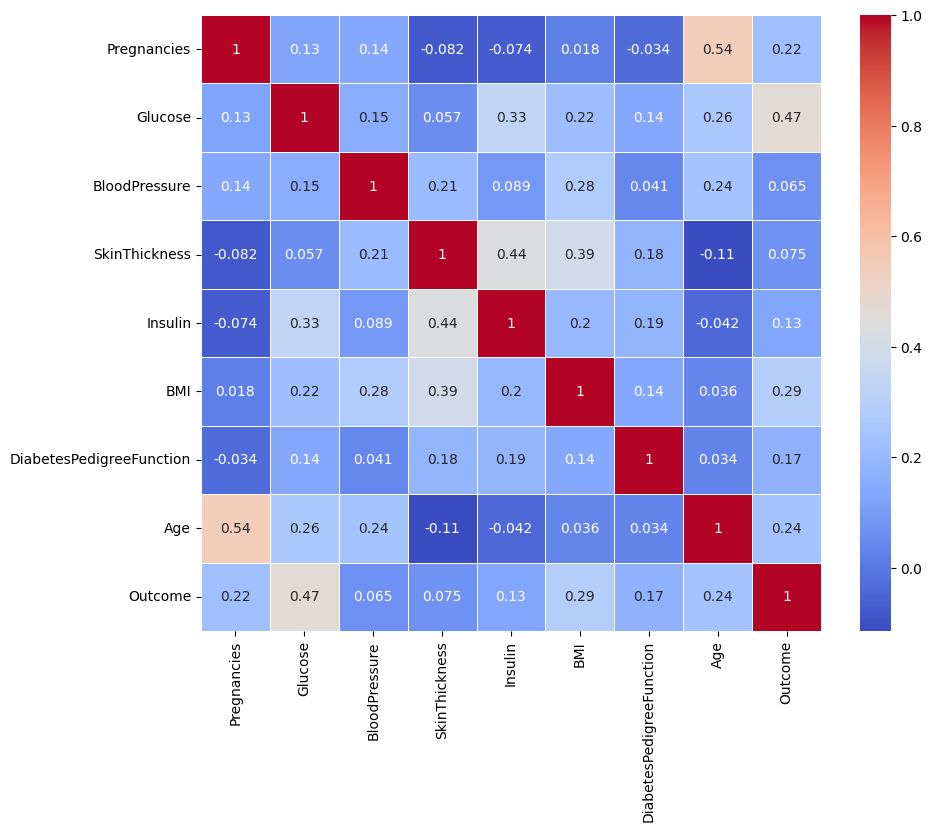

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.show()
cor= df.corr()
print(cor)

plt.figure(figsize=(10, 8))
sns.heatmap(cor, annot=True, cmap="coolwarm", linewidths=0.5)


7- 0 olan değerler olduğu için o değerler boş değer olarak kabul etmek gerekir. Çünkü hastanın kan şekeri 0 olamaz. Bu yüzden 0 yerine NaN ifadesini yazmamız gerekmektedir.

In [11]:


for col in df.columns:
    if col in ["Outcome", "Pregnancies"]:
        continue
    else:
        df[col] = df[col].replace(0, np.nan)


df.isnull().sum()
t1 = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])
for col in df.columns:
    #
    missing_count = df[col].isna().sum()

    # Eksik değer yüzdesi
    missing_percentage = (missing_count / len(df)) * 100

    # Tabloya satır ekleme
    t1.add_row([col, missing_count, f"{missing_percentage:.2f}%"])

print(t1)


+--------------------------+----------------+--------------------+
|       Column Name        | Missing Values | Missing Percentage |
+--------------------------+----------------+--------------------+
|       Pregnancies        |       0        |       0.00%        |
|         Glucose          |       5        |       0.65%        |
|      BloodPressure       |       35       |       4.56%        |
|      SkinThickness       |      227       |       29.56%       |
|         Insulin          |      374       |       48.70%       |
|           BMI            |       11       |       1.43%        |
| DiabetesPedigreeFunction |       0        |       0.00%        |
|           Age            |       0        |       0.00%        |
|         Outcome          |       0        |       0.00%        |
+--------------------------+----------------+--------------------+


8- Eksik olan değerleri doldurmak gerekir.
Mod,median yöntemi ile doldurabiliriz. Yada değer atama yöntemi kullanabiliriz.
Eğer eksik değerler %80'den fazla ise silme yöntemi de uygulayabiliriz.
Veri setine göre yapacağımız işlem değişebilir. 

In [12]:
df=df.apply(lambda x: x.fillna(x.mode()[0]) if x.dtype not in ['object', 'category'] else x, axis=0)  # eksik değerleri ortalama ile doldururuz.
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

9- Veri setine yeni sütunlar ekleyebiliriz. Mesela BMI değerlerini gruplandırarak yeni bir sütun oluşturulabilir. Bu sütunlar zayıf,normal,fazla kilolu ve obez şeklinde olabilir.
Aynı şekilde yaş değişkeninede yapılabilir.

In [13]:

# Yaş grubunu belirleme fonksiyonu

df['age_group'] = pd.cut(df['Age'], bins=[0, 14,65,100], labels=['Çocuk', 'Çalışan Nüfus', 'Yaşlı'])
df.groupby("age_group")["Outcome"].mean()



# BMI'ye göre kategoriler oluşturma
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100], labels=['Zayıf', 'Normal', 'Fazla Kilolu', 'Obesite'])
df.groupby("BMI_Category")["Outcome"].mean()

# Gebelik sayısına göre kategoriler oluşturma
df['Pregnancy_Category'] = pd.cut(df['Pregnancies'], bins=[0, 1, 3, 6, np.inf], labels=['0', '1-3', '4-6', '7+'])
df.head()

/tmp/ipykernel_17/1306814102.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("age_group")["Outcome"].mean()
/tmp/ipykernel_17/1306814102.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("BMI_Category")["Outcome"].mean()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_group,BMI_Category,Pregnancy_Category
0,6,148.000,72.000,35.000,105.000,33.600,0.627,50,1,Çalışan Nüfus,Obesite,4-6
1,1,85.000,66.000,29.000,105.000,26.600,0.351,31,0,Çalışan Nüfus,Fazla Kilolu,0
2,8,183.000,64.000,32.000,105.000,23.300,0.672,32,1,Çalışan Nüfus,Normal,7+
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Çalışan Nüfus,Fazla Kilolu,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Çalışan Nüfus,Obesite,NaN


10- Encoding işlemleri uygulama. Kategorik değişkenlere uygulanır.
Label Encoding --> 2 farklı değer var ise yada aralarında bir üstünlük var ise kullanılır.
One Hot Encodin --> Aralarında herhangi bir üstünlük yok ise kullanılabilir.


In [14]:
# 2 değişkeni olankalr için uygulanır.
def label_encoder(dataframe, binary_cols):
    labelencoder = LabelEncoder()
    for binary_col in binary_cols:
        dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_cols = [col for col in df.columns if df[col].dtype != [[int, float]]
               and df[col].nunique() == 2]
label_encoder(df,binary_cols)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_group,BMI_Category,Pregnancy_Category
0,6,148.000,72.000,35.000,105.000,33.600,0.627,50,1,1,Obesite,4-6
1,1,85.000,66.000,29.000,105.000,26.600,0.351,31,0,1,Fazla Kilolu,0
2,8,183.000,64.000,32.000,105.000,23.300,0.672,32,1,1,Normal,7+
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,1,Fazla Kilolu,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,1,Obesite,NaN


In [15]:
# 2'den fazla değişken mevcut fakat aralarında bir üstünlük mevcut. Hamilelik sayısısı arttıkça diabet olma riskide artmaktadır.
le=LabelEncoder()
df["Pregnancy_Category"]=le.fit_transform(df["Pregnancy_Category"])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_group,BMI_Category,Pregnancy_Category
0,6,148.000,72.000,35.000,105.000,33.600,0.627,50,1,1,Obesite,2
1,1,85.000,66.000,29.000,105.000,26.600,0.351,31,0,1,Fazla Kilolu,0
2,8,183.000,64.000,32.000,105.000,23.300,0.672,32,1,1,Normal,3
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,1,Fazla Kilolu,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,1,Obesite,4


In [16]:
# 2'den fazla değişken var ve aralarında bir üstünlük olmadığı için one hot encoding işlemi yapılır.
pd.get_dummies(df, columns=["age_group", "BMI_Category"], drop_first=True).astype("int").head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancy_Category,age_group_1,BMI_Category_Normal,BMI_Category_Fazla Kilolu,BMI_Category_Obesite
0,6,148,72,35,105,33,0,50,1,2,1,0,0,1
1,1,85,66,29,105,26,0,31,0,0,1,0,1,0
2,8,183,64,32,105,23,0,32,1,3,1,1,0,0
3,1,89,66,23,94,28,0,21,0,0,1,0,1,0
4,0,137,40,35,168,43,2,33,1,4,1,0,0,1


11-Standartlaşma İşlemlerini Uygulama 
Verilerde ki aykırılıklığı önlemek için kullanılır.
Verilerin dağılımını düzenleştirir.
Stokastik gradyan inişi gibi optimizasyon algoritmaları, daha hızlı ve daha etkili bir şekilde çalışmak için standartlaştırılmış verilere ihtiyaç duyar.

MinMax Scaler
RobustScaler
StandartScaler
gibi yöntemler mevcuttur.

In [17]:
mms = MinMaxScaler()
df[num_cols]=mms.fit_transform(df[num_cols])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_group,BMI_Category,Pregnancy_Category
0,0.353,0.671,0.490,0.304,0.109,0.315,0.234,0.483,1,1,Obesite,2
1,0.059,0.265,0.429,0.239,0.109,0.172,0.117,0.167,0,1,Fazla Kilolu,0
2,0.471,0.897,0.408,0.272,0.109,0.104,0.254,0.183,1,1,Normal,3
3,0.059,0.290,0.429,0.174,0.096,0.202,0.038,0.000,0,1,Fazla Kilolu,0
4,0.000,0.600,0.163,0.304,0.185,0.509,0.944,0.200,1,1,Obesite,4


12-Model Oluşturma

In [18]:

df=df.drop(columns=["age_group","BMI_Category"])
y_train=df["Outcome"]
x_train=df.drop(["Outcome"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.30,random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)
pd.DataFrame({"Tahmin":pred,"Sonuç":y_test})

rf=RandomForestClassifier()
rf.fit(X_train,y_train)
pred2=rf.predict(X_test)
accuracy_score=accuracy_score(y_test,pred2)
print(accuracy_score)

0.7272727272727273
0.7402597402597403
